Imports

In [ ]:
import os
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline # 
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc
)

import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from xgboost import XGBClassifier
import math
import joblib
import random







Load the dataset

In [12]:
# Get the parent directory (DS3000-Group-4) and navigate to Data
current_dir = os.getcwd()
data_path = os.path.join(os.path.dirname(current_dir), 'Data', 'mxmh_survey_results.csv')

df = pd.read_csv(data_path) # Load the dataset
df = df.drop(columns=['Exploratory', 'Timestamp', 
                      'Primary streaming service', 'BPM', 'Music effects', 'Permissions']) # Drop unnecessary columns
df = df.dropna() # Drop rows with any missing values
df.head() # Display the first few rows of the cleaned dataset

,Age,Hours per day,While working,Instrumentalist,Composer,Fav genre,Foreign languages,Frequency [Classical],Frequency [Country],Frequency [EDM],...,Frequency [Metal],Frequency [Pop],Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety,Depression,Insomnia,OCD
0,18.0,3.0,Yes,Yes,Yes,Latin,Yes,Rarely,Never,Rarely,...,Never,Very frequently,Sometimes,Very frequently,Never,Sometimes,3.0,0.0,1.0,0.0
1,63.0,1.5,Yes,No,No,Rock,No,Sometimes,Never,Never,...,Never,Sometimes,Sometimes,Rarely,Very frequently,Rarely,7.0,2.0,2.0,1.0
2,18.0,4.0,No,No,No,Video game music,Yes,Never,Never,Very frequently,...,Sometimes,Rarely,Never,Rarely,Rarely,Very frequently,7.0,7.0,10.0,2.0
3,61.0,2.5,Yes,No,Yes,Jazz,Yes,Sometimes,Never,Never,...,Never,Sometimes,Sometimes,Never,Never,Never,9.0,7.0,3.0,3.0
4,18.0,4.0,Yes,No,No,R&B,No,Never,Never,Rarely,...,Never,Sometimes,Very frequently,Very frequently,Never,Rarely,7.0,2.0,5.0,9.0


Visualise distribution of genre preferences

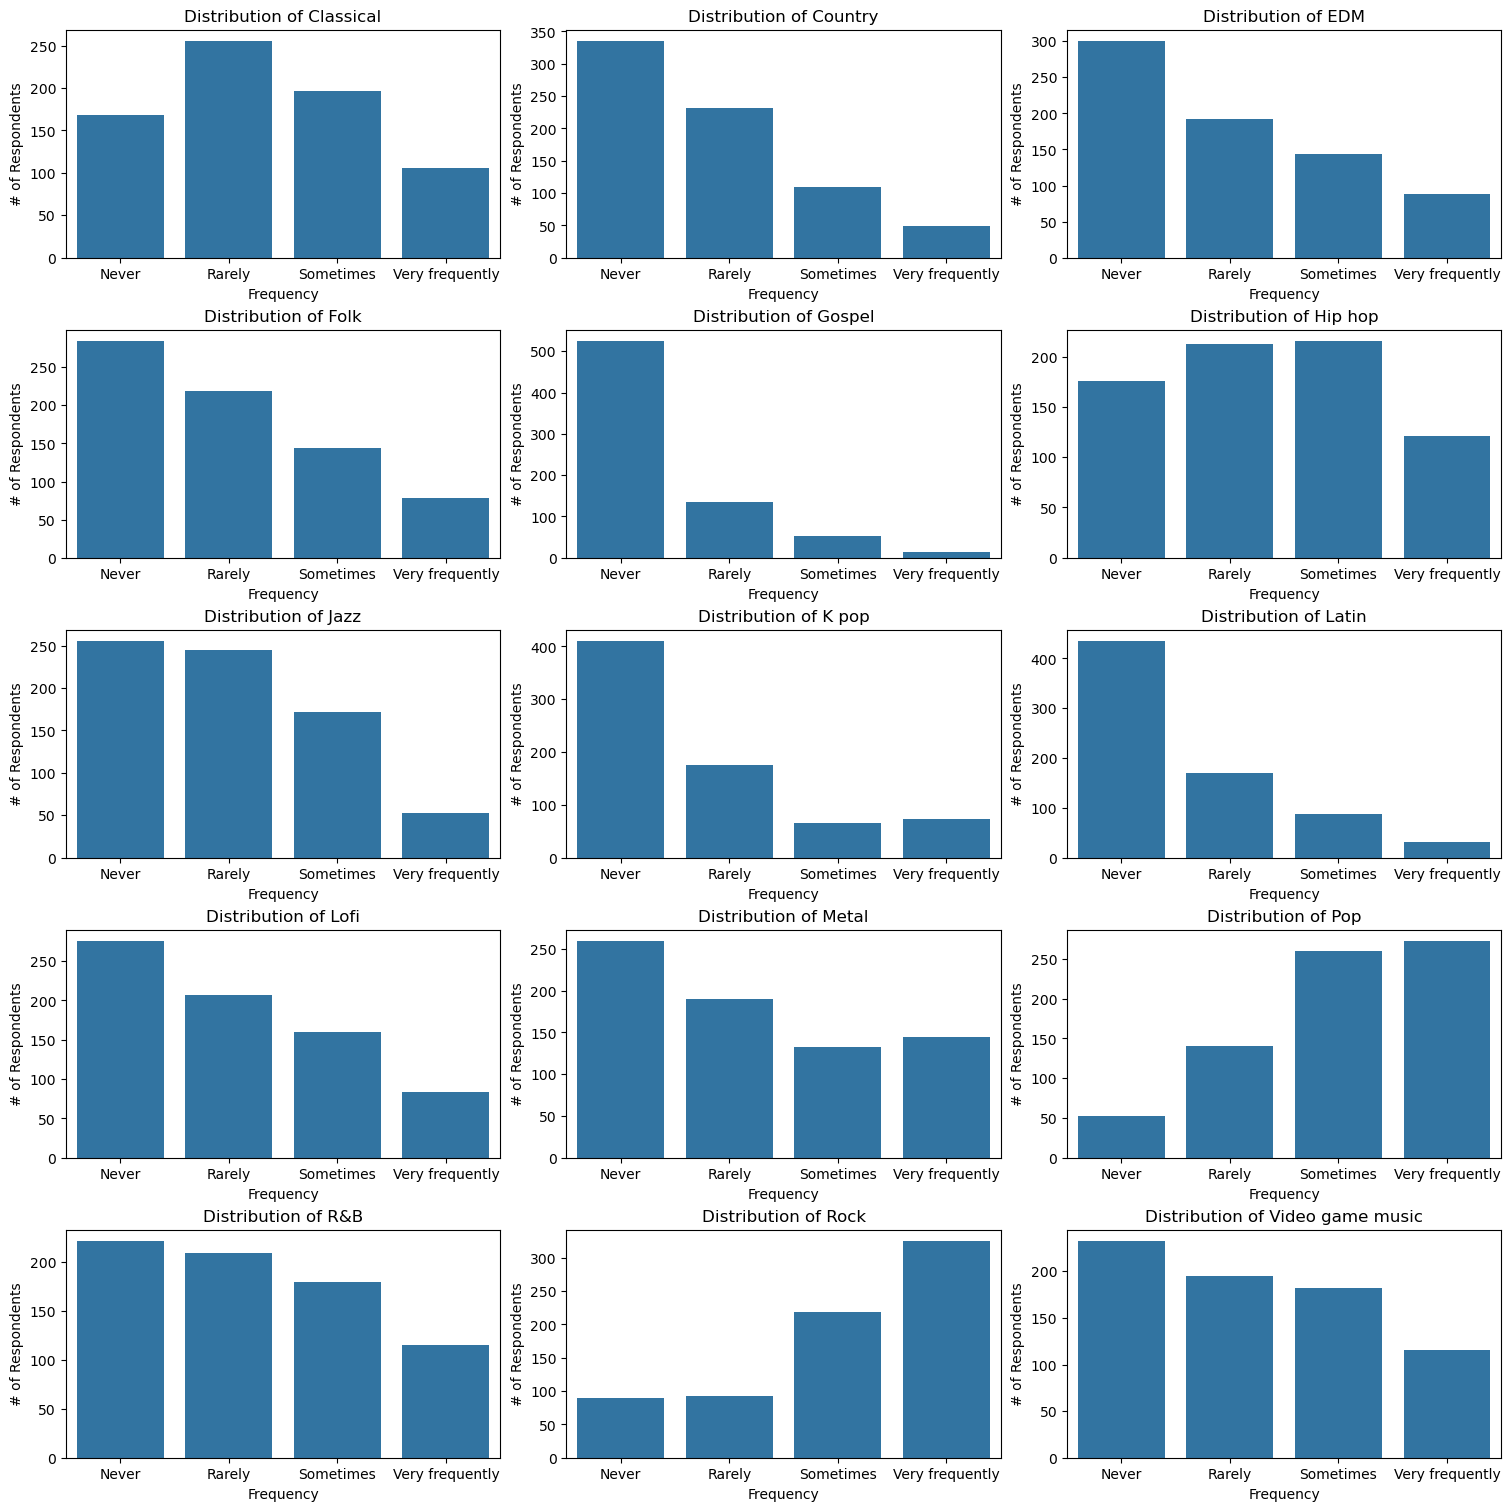

In [13]:
# Plot the distribution of each genre frequency in a grid
mh_condition = ['Classical', 'Country', 'EDM', 'Folk', 'Gospel', 'Hip hop', 'Jazz', 'K pop',
                 'Latin', 'Lofi', 'Metal', 'Pop', 'R&B', 'Rock', 'Video game music']

# Resolve actual dataframe column names (handles either "Genre" or "Frequency [Genre]" style)
mh_col_names = []
for g in mh_condition:
    candidate = f'Frequency [{g}]'
    if candidate in df.columns:
        mh_col_names.append(candidate)
    elif g in df.columns:
        mh_col_names.append(g)
    else:
        print(f"Warning: column for genre '{g}' not found in df")

if not mh_col_names:
    raise RuntimeError("No genre columns found to plot")

# Frequency order
freq_order = ['Never', 'Rarely', 'Sometimes', 'Very frequently']

# Layout: choose number of columns and compute rows
n = len(mh_col_names)
ncols = 3                  # change to 4 or 2 as you prefer
nrows = math.ceil(n / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5, nrows*3), constrained_layout=True)

# Flatten axes for easy iteration
if isinstance(axes, np.ndarray):
    axes_list = axes.flatten()
else:
    axes_list = [axes]

# Plot into each axis
for ax, col in zip(axes_list, mh_col_names):
    s = df[col].dropna()
    # Ensure categorical with explicit order
    s = pd.Categorical(s, categories=freq_order, ordered=True)
    sns.countplot(x=s, ax=ax, color='C0', order=freq_order)
    # nicer title (strip 'Frequency []' wrapper if present)
    title = col.replace('Frequency [', '').replace(']', '')
    ax.set_title(f'Distribution of {title}')
    ax.set_xlabel('Frequency')
    ax.set_ylabel('# of Respondents')

# Hide any unused axes
for ax in axes_list[len(mh_col_names):]:
    ax.set_visible(False)

plt.show()

In [14]:
# Drop gospel and latin, as we do not have enough data points on those who listen to it sometimes or very frequently
df = df.drop(columns=['Frequency [Gospel]', 'Frequency [Latin]'])

Visualise dsitribution of Other Features

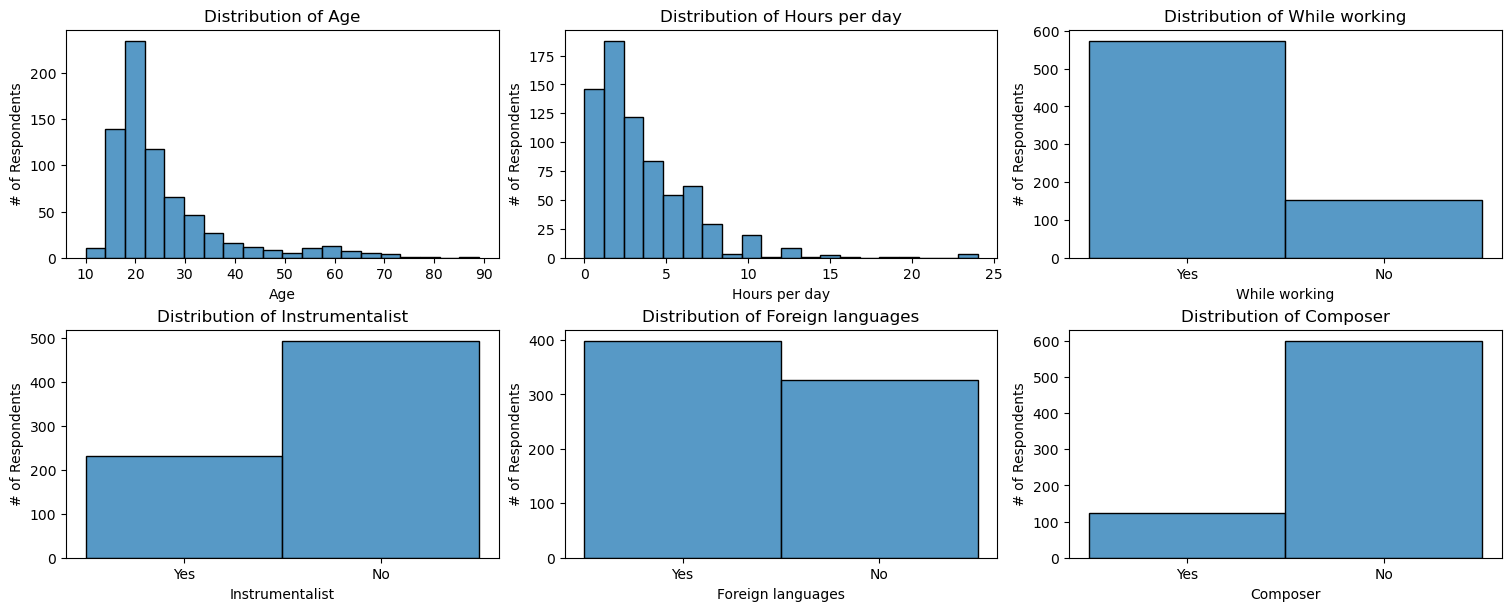

In [15]:
# Plot the distribution of Non-Genre Features
mh_condition = ['Age', 'Hours per day', 'While working', 'Instrumentalist', 'Foreign languages', 'Composer' ]

# Resolve actual dataframe column names (handles either "Genre" or "Frequency [Genre]" style)
mh_col_names = []
for g in mh_condition:
    candidate = f'[{g}]'
    if candidate in df.columns:
        mh_col_names.append(candidate)
    elif g in df.columns:
        mh_col_names.append(g)
    else:
        print(f"Warning: column for feature '{g}' not found in df")

if not mh_col_names:
    raise RuntimeError("No feature columns found to plot")

# Layout: choose number of columns and compute rows
n = len(mh_col_names)
ncols = 3                  # change to 4 or 2 as you prefer
nrows = math.ceil(n / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5, nrows*3), constrained_layout=True)

# Flatten axes for easy iteration
if isinstance(axes, np.ndarray):
    axes_list = axes.flatten()
else:
    axes_list = [axes]

# Plot into each axis
for ax, col in zip(axes_list, mh_col_names):
    sns.histplot(df[col].dropna(), bins=20, kde=False, ax=ax, color='C0')
    # nicer title (strip 'Frequency []' wrapper if present)
    title = col.replace('Frequency [', '').replace(']', '')
    ax.set_title(f'Distribution of {title}')
    ax.set_xlabel(col)
    ax.set_ylabel('# of Respondents')

# Hide any unused axes
for ax in axes_list[len(mh_col_names):]:
    ax.set_visible(False)

plt.show()    

Visualise the distribution of mental health conditions

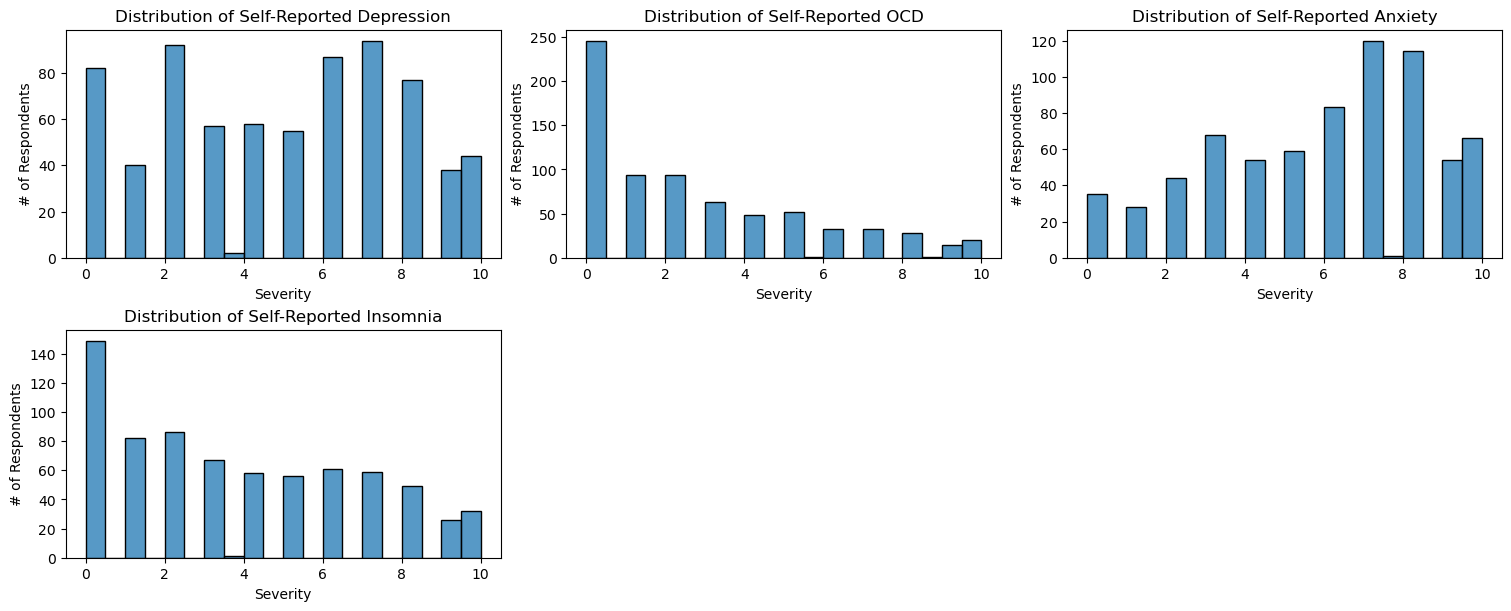

In [16]:
# Plot the distribution of each genre frequency in a grid
mh_condition = ['Depression', 'OCD', 'Anxiety', 'Insomnia' ]

# Resolve actual dataframe column names (handles either "Genre" or "Frequency [Genre]" style)
mh_col_names = []
for g in mh_condition:
    candidate = f'[{g}]'
    if candidate in df.columns:
        mh_col_names.append(candidate)
    elif g in df.columns:
        mh_col_names.append(g)
    else:
        print(f"Warning: column for genre '{g}' not found in df")

if not mh_col_names:
    raise RuntimeError("No MH columns found to plot")

# Layout: choose number of columns and compute rows
n = len(mh_col_names)
ncols = 3                  # change to 4 or 2 as you prefer
nrows = math.ceil(n / ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5, nrows*3), constrained_layout=True)

# Flatten axes for easy iteration
if isinstance(axes, np.ndarray):
    axes_list = axes.flatten()
else:
    axes_list = [axes]

# Plot into each axis
for ax, col in zip(axes_list, mh_col_names):
    sns.histplot(df[col].dropna(), bins=20, kde=False, ax=ax, color='C0')
    # nicer title (strip 'Frequency []' wrapper if present)
    title = col.replace('Severity [', '').replace(']', '')
    ax.set_title(f'Distribution of Self-Reported {title}')
    ax.set_xlabel('Severity')
    ax.set_ylabel('# of Respondents')

# Hide any unused axes
for ax in axes_list[len(mh_col_names):]:
    ax.set_visible(False)

plt.show()

We see that we do not have many respondants reporting symptoms of OCD. Therefore, we may not be able to accurately model music-factor trends relating to higher/lower levels of OCD.

We notice that most respondants experience moderate to high anxiety.

We notice that we have good balance of respondants experiencing various levels of depression. We may have more success forecasting this.

In [17]:
# Frame mental health condition columns as classification targets
mh_condition = ['Depression', 'OCD', 'Anxiety', 'Insomnia' ]

def to_3class(score_series):
    """
    Map numeric scores to 3 classes:
    0–3  -> 0 (Low)
    4–6  -> 1 (Moderate)
    7–10 -> 2 (High)
    """
    bins = [-np.inf, 3.0, 6.0, np.inf] # Define class bin edges
    labels = [0, 1, 2] # Corresponding class labels
    return pd.cut(score_series, bins=bins, labels=labels).astype(int) # Convert to int type


# Convert target columns if they exist
target_conditions = ['Anxiety', 'Depression', 'Insomnia', 'OCD']
for t in target_conditions:
    if t in df.columns:
        df[f"{t}_class"] = to_3class(df[t])

# Drop original target columns if they exist
existing_targets = [t for t in target_conditions if t in df.columns]
if existing_targets:
    df = df.drop(columns=existing_targets)    

df.head()


,Age,Hours per day,While working,Instrumentalist,Composer,Fav genre,Foreign languages,Frequency [Classical],Frequency [Country],Frequency [EDM],...,Frequency [Metal],Frequency [Pop],Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety_class,Depression_class,Insomnia_class,OCD_class
0,18.0,3.0,Yes,Yes,Yes,Latin,Yes,Rarely,Never,Rarely,...,Never,Very frequently,Sometimes,Very frequently,Never,Sometimes,0,0,0,0
1,63.0,1.5,Yes,No,No,Rock,No,Sometimes,Never,Never,...,Never,Sometimes,Sometimes,Rarely,Very frequently,Rarely,2,0,0,0
2,18.0,4.0,No,No,No,Video game music,Yes,Never,Never,Very frequently,...,Sometimes,Rarely,Never,Rarely,Rarely,Very frequently,2,2,2,0
3,61.0,2.5,Yes,No,Yes,Jazz,Yes,Sometimes,Never,Never,...,Never,Sometimes,Sometimes,Never,Never,Never,2,2,0,0
4,18.0,4.0,Yes,No,No,R&B,No,Never,Never,Rarely,...,Never,Sometimes,Very frequently,Very frequently,Never,Rarely,2,0,1,2


In [18]:
# Convert favourite genre into a boost applied to the users favourite genre frequency


# Define frequency mapping
freq_map = {
    "Never": 0,
    "Rarely": 1,
    "Sometimes": 2,
    "Frequently": 3,
    "Very frequently": 4
}

# Copy df to avoid mutating original
df_fe = df.copy()

# Identify genre frequency columns
freq_cols = [col for col in df.columns if col.startswith("Frequency")]


# Convert frequency columns to numeric using the mapping
for col in freq_cols:
    df_fe[col] = df_fe[col].map(freq_map).astype(float)


# Create a normalised genre name lookup so "Fav genre" matches frequency column names
# Example: "Rock" → "Frequency [Rock]"
def genre_to_freq_column(genre):
    return f"Frequency [{genre}]"

fav_genre_boost = 1.0   # Boost amount 1.0 to add to favourite genre frequency

# Convert favourite genre into frequency column name
def convert_fav_genre_to_freq_col(genre):
    return f"Frequency [{genre}]"

# Apply boost to favourite genre frequency
for idx, row in df_fe.iterrows():
    fav = row["Fav genre"]
    target_col = convert_fav_genre_to_freq_col(fav)

    if target_col in freq_cols:
        df_fe.loc[idx, target_col] = df_fe.loc[idx, target_col] + fav_genre_boost

# Drop original Fav genre column 
df_fe = df_fe.drop(columns=["Fav genre"])

# Display the processed dataframe
df_fe.head()


,Age,Hours per day,While working,Instrumentalist,Composer,Foreign languages,Frequency [Classical],Frequency [Country],Frequency [EDM],Frequency [Folk],...,Frequency [Metal],Frequency [Pop],Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety_class,Depression_class,Insomnia_class,OCD_class
0,18.0,3.0,Yes,Yes,Yes,Yes,1.0,0.0,1.0,0.0,...,0.0,4.0,2.0,4.0,0.0,2.0,0,0,0,0
1,63.0,1.5,Yes,No,No,No,2.0,0.0,0.0,1.0,...,0.0,2.0,2.0,1.0,5.0,1.0,2,0,0,0
2,18.0,4.0,No,No,No,Yes,0.0,0.0,4.0,0.0,...,2.0,1.0,0.0,1.0,1.0,5.0,2,2,2,0
3,61.0,2.5,Yes,No,Yes,Yes,2.0,0.0,0.0,1.0,...,0.0,2.0,2.0,0.0,0.0,0.0,2,2,0,0
4,18.0,4.0,Yes,No,No,No,0.0,0.0,1.0,0.0,...,0.0,2.0,5.0,4.0,0.0,1.0,2,0,1,2


In [ ]:
# Start from a clean copy of the original dataframe
df_fe1 = df_fe.copy()

# Clean col names to avoid key errors
df_fe1.columns = (
    df_fe1.columns.astype(str)
    .str.strip()
    .str.replace('\xa0', '', regex=False)
    .str.replace(r'\s+', ' ', regex=True)
)

print("Cleaned column names:", df_fe1.columns.tolist())

# Define age group bins and labels
age_bins = [0, 17, 25, 35, 45, 55, 65, np.inf]
age_labels = ['<18', '18-24', '25-34', '35-44', '45-54', '55-64', '65+']

if 'Age' not in df_fe1.columns:
    raise KeyError("'Age' column not found in dataframe.")

# Create Age Group categorical feature
df_fe1['Age Group'] = pd.cut(
    df_fe1['Age'], bins=age_bins, labels=age_labels
)

# One-hot encode Age Group (categorical, not ordinal!)
df_fe1 = pd.get_dummies(df_fe1, columns=['Age Group'], prefix='AgeGroup')

# Drop the original Age column if not needed
df_fe1 = df_fe1.drop(columns=['Age'])

# Identify Yes/No columns
yes_no_cols = []
for col in df_fe1.columns:
    nonnull = df_fe1[col].dropna().unique()
    if len(nonnull) > 0 and set(nonnull).issubset({'Yes', 'No'}):
        yes_no_cols.append(col)
    if len(nonnull) > 0 and set(nonnull).issubset({'True', 'False'}):
        yes_no_cols.append(col)

print("Detected Yes/No columns:", yes_no_cols)

# Convert boolean to binary 1/0
for col in yes_no_cols:
    df_fe1[col] = df_fe1[col].map({'Yes': 1, 'No': 0, 'True': 1, 'False': 0})

# Conver true false to binary 1/0
for col in df_fe1.columns:
    if df_fe1[col].dtype == bool:
        df_fe1[col] = df_fe1[col].astype(int)

df_fe1.head(10) # Display the first 10 rows of the final feature-engineered dataframe

# Save the final preprocessed dataframe to a new CSV file
processed_data_path = os.path.join(os.path.dirname(current_dir), 'Data', 'mxmh_survey_results_processed.csv')
df_fe1.to_csv(processed_data_path, index=False)

# Print message to confirm saving
print(f"Processed data saved to {processed_data_path}")


Cleaned column names: ['Age', 'Hours per day', 'While working', 'Instrumentalist', 'Composer', 'Foreign languages', 'Frequency [Classical]', 'Frequency [Country]', 'Frequency [EDM]', 'Frequency [Folk]', 'Frequency [Hip hop]', 'Frequency [Jazz]', 'Frequency [K pop]', 'Frequency [Lofi]', 'Frequency [Metal]', 'Frequency [Pop]', 'Frequency [R&B]', 'Frequency [Rap]', 'Frequency [Rock]', 'Frequency [Video game music]', 'Anxiety_class', 'Depression_class', 'Insomnia_class', 'OCD_class']
Detected Yes/No columns: ['While working', 'Instrumentalist', 'Composer', 'Foreign languages']
Processed data saved to c:\Users\hanna\Documents\DS3000\DS3000-Group-4\Data\mxmh_survey_results_processed.csv


[I 2025-12-01 17:59:15,324] A new study created in memory with name: no-name-76b086ee-3b3a-4493-914f-4ea448d11473
[I 2025-12-01 17:59:15,616] Trial 0 finished with value: 0.2869669883907721 and parameters: {'n_estimators': 387, 'learning_rate': 0.24149063376556343, 'max_depth': 7, 'subsample': 0.9176164739010126, 'colsample_bytree': 0.7349984536727807, 'gamma': 1.9957315512940446, 'min_child_weight': 9}. Best is trial 0 with value: 0.2869669883907721.
[I 2025-12-01 17:59:16,094] Trial 1 finished with value: 0.3754681558874775 and parameters: {'n_estimators': 363, 'learning_rate': 0.054157947480388303, 'max_depth': 7, 'subsample': 0.9239049838298441, 'colsample_bytree': 0.9445425494888064, 'gamma': 0.19384620930525442, 'min_child_weight': 6}. Best is trial 1 with value: 0.3754681558874775.
[I 2025-12-01 17:59:16,334] Trial 2 finished with value: 0.38078774966929907 and parameters: {'n_estimators': 269, 'learning_rate': 0.13009422870986828, 'max_depth': 8, 'subsample': 0.7539521247599117

Best hyperparameters: {'n_estimators': 244, 'learning_rate': 0.08655006731697928, 'max_depth': 4, 'subsample': 0.7793609912707803, 'colsample_bytree': 0.8072696175413898, 'gamma': 0.05316013320321468, 'min_child_weight': 7}

Evaluation on test set:
Accuracy: 0.4383561643835616
Precision: 0.3415284924718887
Recall: 0.33921568627450976
F1 Score: 0.3188317558716629
ROC AUC: 0.4880341932228724

Classification report:
              precision    recall  f1-score   support

           0       0.18      0.12      0.14        17
           1       0.33      0.15      0.21        20
           2       0.51      0.75      0.61        36

    accuracy                           0.44        73
   macro avg       0.34      0.34      0.32        73
weighted avg       0.38      0.44      0.39        73



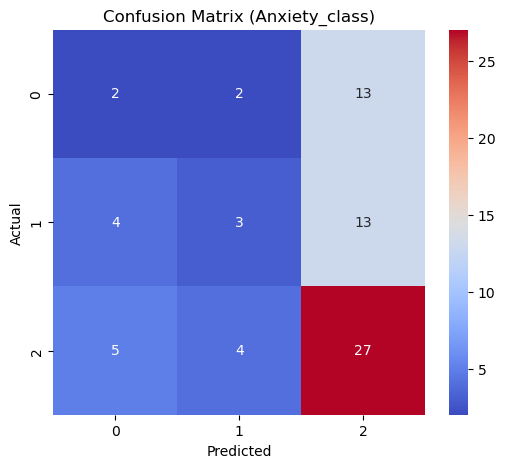

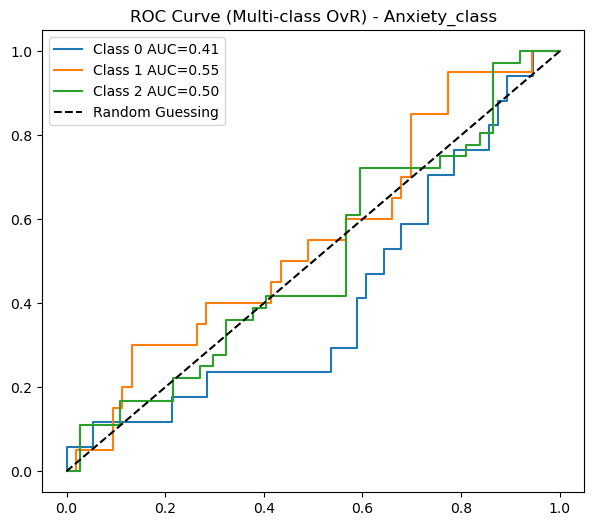

[I 2025-12-01 17:59:28,364] A new study created in memory with name: no-name-003674f2-a139-4f8f-af26-033cad0e899b


Saved model to: c:\Users\hanna\Documents\DS3000\DS3000-Group-4\models\xgboost_anxiety_model.pkl


[I 2025-12-01 17:59:28,694] Trial 0 finished with value: 0.3756776747327401 and parameters: {'n_estimators': 226, 'learning_rate': 0.03460040855566941, 'max_depth': 6, 'subsample': 0.7833718832131917, 'colsample_bytree': 0.7360900597579688, 'gamma': 1.7990911990568614, 'min_child_weight': 2}. Best is trial 0 with value: 0.3756776747327401.
[I 2025-12-01 17:59:28,919] Trial 1 finished with value: 0.3887340914638464 and parameters: {'n_estimators': 138, 'learning_rate': 0.1854718156247352, 'max_depth': 8, 'subsample': 0.7222436251681811, 'colsample_bytree': 0.7390872650741503, 'gamma': 1.5731361576374832, 'min_child_weight': 2}. Best is trial 1 with value: 0.3887340914638464.
[I 2025-12-01 17:59:29,134] Trial 2 finished with value: 0.3747153808811237 and parameters: {'n_estimators': 122, 'learning_rate': 0.1394619260630842, 'max_depth': 5, 'subsample': 0.7411874971850636, 'colsample_bytree': 0.860554752319501, 'gamma': 1.390066001689531, 'min_child_weight': 7}. Best is trial 1 with value

Best hyperparameters: {'n_estimators': 370, 'learning_rate': 0.1744861861956265, 'max_depth': 5, 'subsample': 0.8070665662610981, 'colsample_bytree': 0.9767456192851351, 'gamma': 1.684404319317442, 'min_child_weight': 4}

Evaluation on test set:
Accuracy: 0.4520547945205479
Precision: 0.46494355317884734
Recall: 0.42796771130104466
F1 Score: 0.4102564102564103
ROC AUC: 0.6080352342880052

Classification report:
              precision    recall  f1-score   support

           0       0.42      0.52      0.47        27
           1       0.50      0.15      0.23        20
           2       0.47      0.62      0.53        26

    accuracy                           0.45        73
   macro avg       0.46      0.43      0.41        73
weighted avg       0.46      0.45      0.43        73



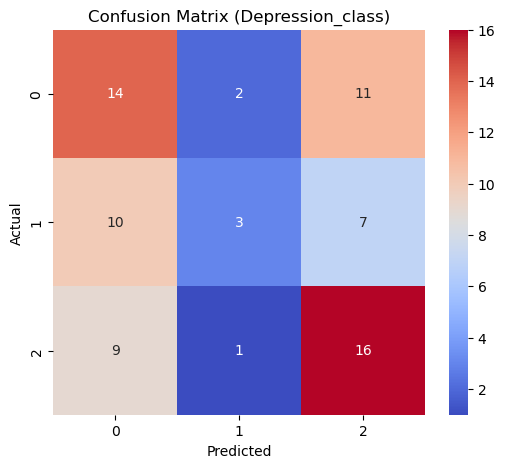

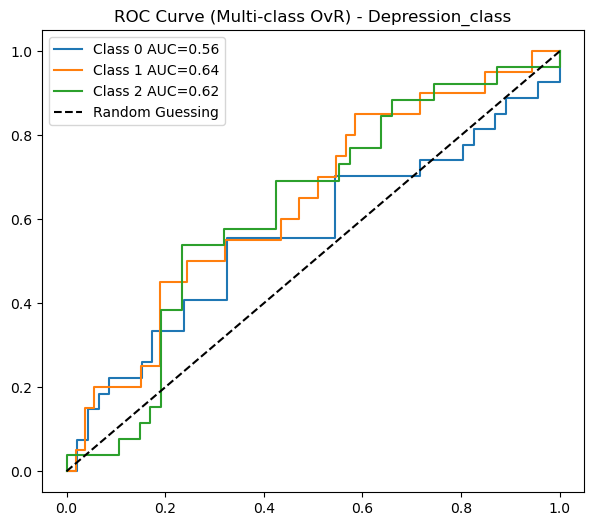

[I 2025-12-01 17:59:39,570] A new study created in memory with name: no-name-50191b73-b999-46a7-ae31-53e77c997554


Saved model to: c:\Users\hanna\Documents\DS3000\DS3000-Group-4\models\xgboost_depression_model.pkl


[I 2025-12-01 17:59:39,892] Trial 0 finished with value: 0.321851291870128 and parameters: {'n_estimators': 231, 'learning_rate': 0.11482143622718197, 'max_depth': 7, 'subsample': 0.9590234840155547, 'colsample_bytree': 0.839145274840001, 'gamma': 1.054588291354078, 'min_child_weight': 10}. Best is trial 0 with value: 0.321851291870128.
[I 2025-12-01 17:59:40,409] Trial 1 finished with value: 0.3523120913194872 and parameters: {'n_estimators': 395, 'learning_rate': 0.03765341117792096, 'max_depth': 3, 'subsample': 0.7514526374280571, 'colsample_bytree': 0.6294240250337235, 'gamma': 0.8524680057589478, 'min_child_weight': 9}. Best is trial 1 with value: 0.3523120913194872.
[I 2025-12-01 17:59:41,133] Trial 2 finished with value: 0.36420973169258236 and parameters: {'n_estimators': 319, 'learning_rate': 0.0993360507374552, 'max_depth': 7, 'subsample': 0.9298788481383901, 'colsample_bytree': 0.9514602306106402, 'gamma': 0.17119567552769022, 'min_child_weight': 4}. Best is trial 2 with val

Best hyperparameters: {'n_estimators': 319, 'learning_rate': 0.0993360507374552, 'max_depth': 7, 'subsample': 0.9298788481383901, 'colsample_bytree': 0.9514602306106402, 'gamma': 0.17119567552769022, 'min_child_weight': 4}

Evaluation on test set:
Accuracy: 0.4931506849315068
Precision: 0.3996825396825397
Recall: 0.3883728930168559
F1 Score: 0.37979254914738786
ROC AUC: 0.5353741975259002

Classification report:
              precision    recall  f1-score   support

           0       0.58      0.76      0.66        38
           1       0.33      0.17      0.22        18
           2       0.29      0.24      0.26        17

    accuracy                           0.49        73
   macro avg       0.40      0.39      0.38        73
weighted avg       0.45      0.49      0.46        73



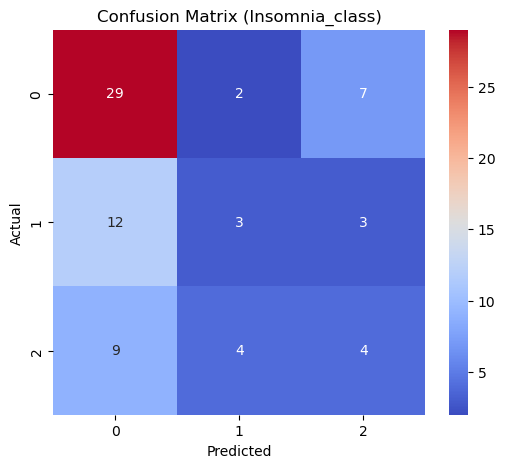

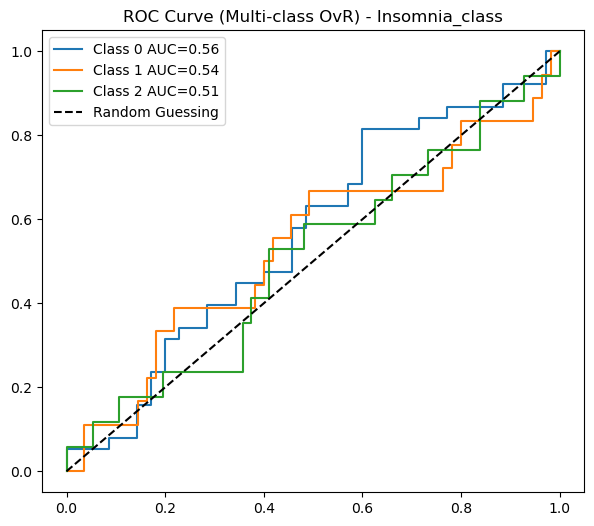

[I 2025-12-01 17:59:54,051] A new study created in memory with name: no-name-bfb39f4b-cbf1-40eb-a5d4-57e1d4984915


Saved model to: c:\Users\hanna\Documents\DS3000\DS3000-Group-4\models\xgboost_insomnia_model.pkl


[I 2025-12-01 17:59:54,303] Trial 0 finished with value: 0.2704321176425522 and parameters: {'n_estimators': 131, 'learning_rate': 0.1489518091153419, 'max_depth': 5, 'subsample': 0.971367338370191, 'colsample_bytree': 0.7199518458941415, 'gamma': 1.6828599108128746, 'min_child_weight': 8}. Best is trial 0 with value: 0.2704321176425522.
[I 2025-12-01 17:59:54,820] Trial 1 finished with value: 0.29974305805820717 and parameters: {'n_estimators': 365, 'learning_rate': 0.13805237381394028, 'max_depth': 8, 'subsample': 0.7002621613395493, 'colsample_bytree': 0.9650257742332838, 'gamma': 1.5241078331416653, 'min_child_weight': 8}. Best is trial 1 with value: 0.29974305805820717.
[I 2025-12-01 17:59:55,462] Trial 2 finished with value: 0.3341555354318875 and parameters: {'n_estimators': 332, 'learning_rate': 0.0692925428609671, 'max_depth': 6, 'subsample': 0.755589537905889, 'colsample_bytree': 0.9934338649746322, 'gamma': 0.6607977023017162, 'min_child_weight': 5}. Best is trial 2 with val

Best hyperparameters: {'n_estimators': 260, 'learning_rate': 0.17335327998112754, 'max_depth': 3, 'subsample': 0.863053244613415, 'colsample_bytree': 0.7510342231963829, 'gamma': 0.008385672875683342, 'min_child_weight': 1}

Evaluation on test set:
Accuracy: 0.6438356164383562
Precision: 0.3141025641025641
Recall: 0.3512820512820513
F1 Score: 0.3243616287094548
ROC AUC: 0.4563771655076003

Classification report:
              precision    recall  f1-score   support

           0       0.69      0.90      0.78        50
           1       0.25      0.15      0.19        13
           2       0.00      0.00      0.00        10

    accuracy                           0.64        73
   macro avg       0.31      0.35      0.32        73
weighted avg       0.52      0.64      0.57        73



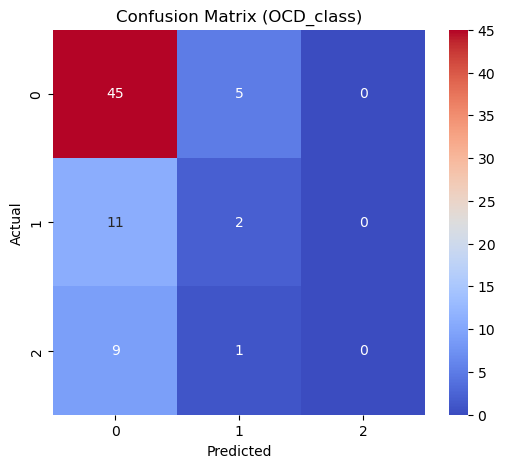

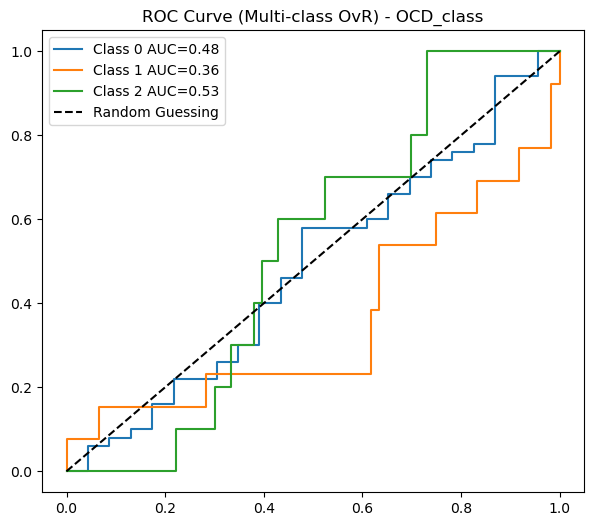

Saved model to: c:\Users\hanna\Documents\DS3000\DS3000-Group-4\models\xgboost_ocd_model.pkl


In [ ]:
# Reusable training + optuna hyperparameter tuning function for any target (e.g., Anxiety_class, Depression_class, Insomnia_class, OCD_class)

# Define function to train, tune, evaluate, and save model
def train_and_eval(target_col, n_trials=50, random_state=42):
    
    # Prepare data based on target column
    if target_col not in df_fe1.columns:
        raise KeyError(f"Target column '{target_col}' not found in dataframe.")

    # Exclude other target columns
    exclude_cols = [c for c in df_fe1.columns if c.endswith('_class')]

    # Prepare features and target
    X = df_fe1.copy().drop(columns=exclude_cols)
    y = df_fe1[target_col].copy()

    # Split data into 80% train and 20% test, stratified by target
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=random_state
    )

    # Preprocessor (numeric features pipeline)
    num_features = X_train.columns.tolist()
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", Pipeline([
                ("impute", SimpleImputer(strategy="median")), # Impute missing values with median
                ("scale", StandardScaler()) # Scale numeric features
            ]), num_features) # All features are numeric
        ]
    )

    # Optuna objective function, which trains and evaluates model with given hyperparameters
    def objective(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 400),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.25),
            "max_depth": trial.suggest_int("max_depth", 3, 8),
            "subsample": trial.suggest_float("subsample", 0.7, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
            "gamma": trial.suggest_float("gamma", 0.0, 2.0),
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
            "objective": "multi:softprob",
            "eval_metric": "mlogloss",
            "tree_method": "hist",
            "random_state": random_state,
            "n_jobs": 1
        }

        # Create XGBoost model with trial params
        model = XGBClassifier(**params) 

        # Build pipeline
        pipe = Pipeline([("prep", preprocessor), ("model", model)])

        # Cross-validation
        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)
        scores = [] # Collect F1 scores across folds

        # Perform cross-validation
        for train_idx, val_idx in cv.split(X_train, y_train):
            X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
            pipe.fit(X_tr, y_tr)
            preds = pipe.predict(X_val)
            score = f1_score(y_val, preds, average="macro")
            scores.append(score)
        return np.mean(scores) # Return average F1 score across folds

    # Create and optimise study to maximise F1 score by tuning hyperparameters
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)

    # Print best performing hyperparameters
    print("Best hyperparameters:", study.best_params)

    # Train final model with best params on full training set
    best_params = study.best_params
    final_model = XGBClassifier(**best_params, objective="multi:softprob", eval_metric="mlogloss", tree_method="hist", random_state=random_state, n_jobs=-1)
    final_pipe = Pipeline([("prep", preprocessor), ("model", final_model)])
    final_pipe.fit(X_train, y_train)

    # Evaluate on test set
    preds = final_pipe.predict(X_test)
    proba = final_pipe.predict_proba(X_test)

    # Compute evaluation metrics
    accuracy = accuracy_score(y_test, preds)
    precision = precision_score(y_test, preds, average="macro")
    recall = recall_score(y_test, preds, average="macro")
    f1 = f1_score(y_test, preds, average="macro")
    try:
        roc_auc = roc_auc_score(label_binarize(y_test, classes=np.unique(y_train)), proba, average="macro", multi_class="ovr")
    except Exception:
        roc_auc = None

    # Print evaluation results
    print("\nEvaluation on test set:")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    if roc_auc is not None:
        print("ROC AUC:", roc_auc)
    print("\nClassification report:")
    print(classification_report(y_test, preds))

    # Confusion matrix
    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix ({target_col})")
    plt.show()

    # Plot ROC curves if available
    if roc_auc is not None:
        plt.figure(figsize=(7,6))
        y_bin = label_binarize(y_test, classes=np.unique(y_train))
        for i in range(proba.shape[1]):
            fpr, tpr, _ = roc_curve(y_bin[:, i], proba[:, i])
            plt.plot(fpr, tpr, label=f"Class {i} AUC={auc(fpr,tpr):.2f}")
        plt.plot([0,1], [0,1], 'k--', label='Random Guessing')
        plt.legend()
        plt.title(f"ROC Curve (Multi-class OvR) - {target_col}")
        plt.show()

    # Save model
    safe_name = target_col.replace('_class','').lower()
    model_path = os.path.join(os.path.dirname(current_dir), 'models', f'xgboost_{safe_name}_model.pkl')
    joblib.dump(final_pipe, model_path)
    print("Saved model to:", model_path)

    return {"target": target_col, "accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1, "roc_auc": roc_auc, "model_path": model_path}

# Run for both Anxiety and Depression (if available)
results = {}
for target in ['Anxiety_class', 'Depression_class', 'Insomnia_class', 'OCD_class']:
    if target in df_fe1.columns:
        results[target] = train_and_eval(target, n_trials=30)
    else:
        print(f"Skipping {target}: column not present")
